In [5]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import gt4py as gt
from gt4py.cartesian import gtscript

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

In [3]:
def initialize_fields(mode="random", order="C"):
    """
    This function initializes the 3D fields with some patterns to help validating
    the stencil update functions.
    """
    # Initialize 3D fields
    rng = np.random.default_rng()

    in_field = np.zeros([NZ, NY, NX], order=order)
    
    if mode == "random":
        rng.random(size=[NZ, NY, NX], out=in_field)
        # Uniformly distributed in [-1, 1)
        in_field = 2 * in_field - 1  
    elif mode == "horizontal-bars":
        in_field[:,: NY//2 : 2, :] = 1
    elif mode == "vertical-bars":
        in_field[:, :,: NX//2 : 2] = 1
    elif mode == "square":
        in_field[:, NY//2 - NY//4 : NY//2 + NY//4, NX//2 - NX//4 : NX//2 + NX//4] = 1
    else:
        raise ValueError("Wrong mode")
    
    out_field = np.copy(in_field)
    
    return in_field, out_field

def plot_field(field, k=0):
    field = np.array(field)
    plt.imshow(field[k, :, :], origin='lower', vmin=-1, vmax=1);
    plt.colorbar();

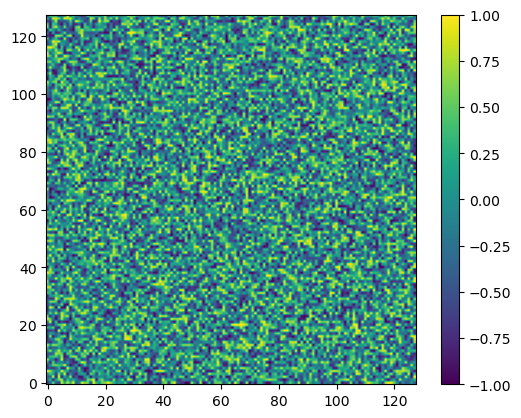

In [4]:
in_field, out_field = initialize_fields(mode="random")
plot_field(in_field)

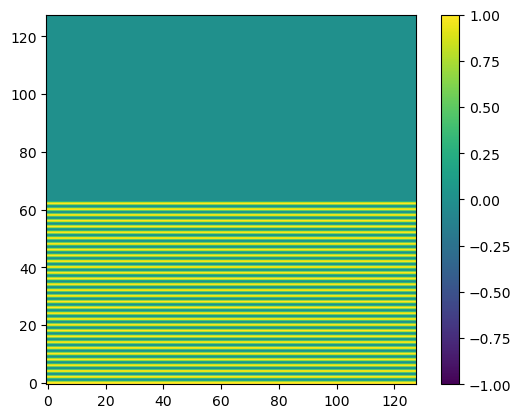

In [5]:
in_field, out_field = initialize_fields(mode="horizontal-bars")
plot_field(in_field)

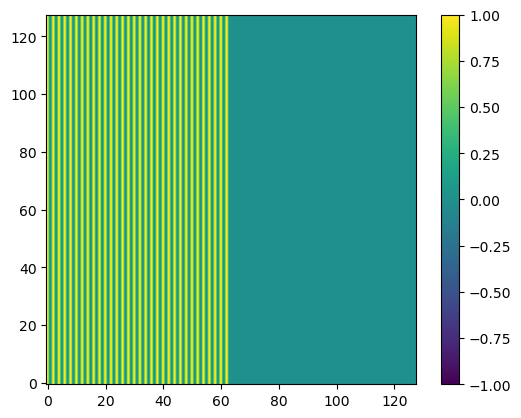

In [6]:
in_field, out_field = initialize_fields(mode="vertical-bars")
plot_field(in_field)

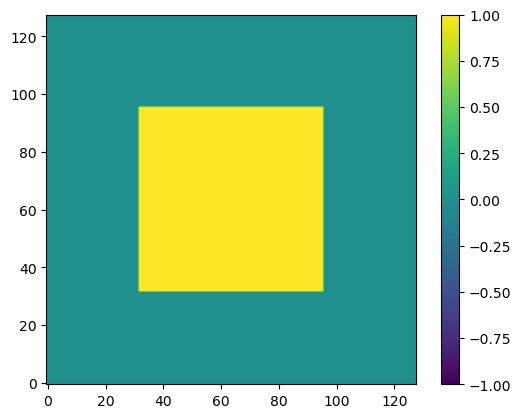

In [7]:
in_field, out_field = initialize_fields(mode="square")
plot_field(in_field)

# Pointwise stencils

$$
a(i) = b(i)
$$

$$
a(i) = \sin(b(i))
$$

In [8]:
def performance_list_pointwise(in_field, out_field, plot=False):
    """
    The simplest pointwise stencil (copy) with list N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """   
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()
    
    if plot:
        plot_field(out_field)
    
    return toc - tic

In [9]:
in_field, out_field = initialize_fields(mode="square")

Lists: 11.63 s
12.6 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


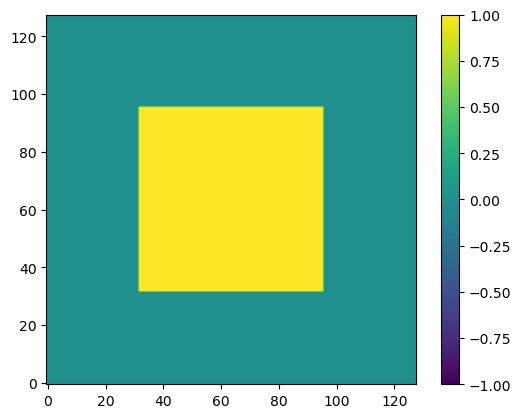

In [10]:
time = performance_list_pointwise(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists: {time:.2f} s")
%timeit performance_list_pointwise(in_field.tolist(), out_field.tolist())

In [11]:
def performance_list_sin_pointwise(in_field, out_field, plot=False):
    """
    Pointwise stencil with lists applying sin() to each point N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    # numpy.sin() is ~7 times slower than math.sin() when applied to single values
                    out_field[k][j][i] = math.sin(in_field[k][j][i])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

Lists (sin): 20.58 s
20.6 s ± 84.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


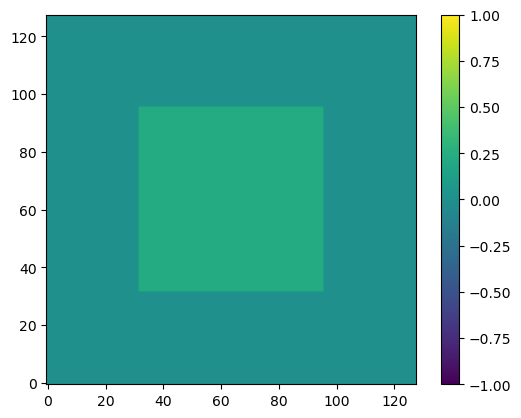

In [12]:
# There is no need to initialize the fields again because tolist() already creates a copy
# so we are not modifying the original arrays
time = performance_list_sin_pointwise(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists (sin): {time:.2f} s")
%timeit performance_list_sin_pointwise(in_field.tolist(), out_field.tolist())

In [13]:
def performance_array_pointwise(in_field, out_field, plot=False):
    """
    The simplest pointwise stencil (copy) with arrays N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()
    
    if plot:
        plot_field(out_field)
    
    return toc - tic

Arrays: 29.88 s
29.9 s ± 58.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


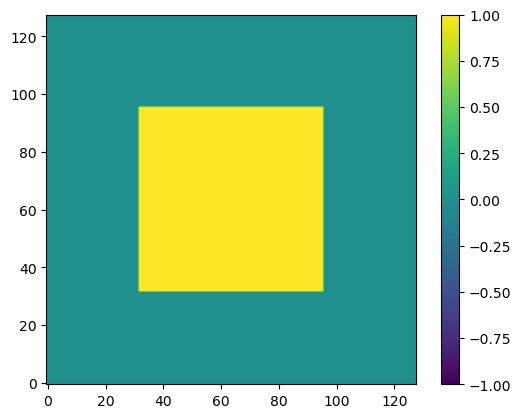

In [14]:
time = performance_array_pointwise(in_field, out_field, plot=True)
print(f"Arrays: {time:.2f} s")
%timeit performance_array_pointwise(in_field, out_field)

In [15]:
def performance_array_sin_pointwise(in_field, out_field, plot=False):
    """
    Pointwise stencil with arrays applying sin() to each point N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)

    return toc - tic

Arrays (sin): 44.39 s


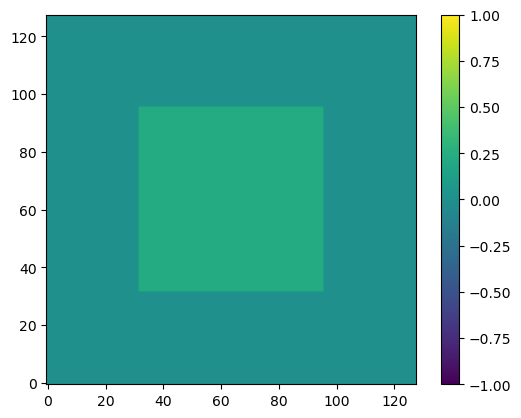

In [16]:
# Now we do need to initialize the fields again because we are passing the numpy
# arrays directly to the functions, so the in_field gets modified
in_field, out_field = initialize_fields(mode="square")
time = performance_array_sin_pointwise(in_field, out_field, plot=True)
print(f"Arrays (sin): {time:.2f} s")

In [17]:
%%timeit
in_field, out_field = initialize_fields(mode="square")
performance_array_sin_pointwise(in_field, out_field)

44.3 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
def performance_array_vectorial_pointwise(in_field, out_field, plot=False):
    """
    The simplest pointwise stencil (copy) with arrays  N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        out_field = in_field.copy()
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
    
    return toc - tic

Arrays (vectorial): 0.31 s


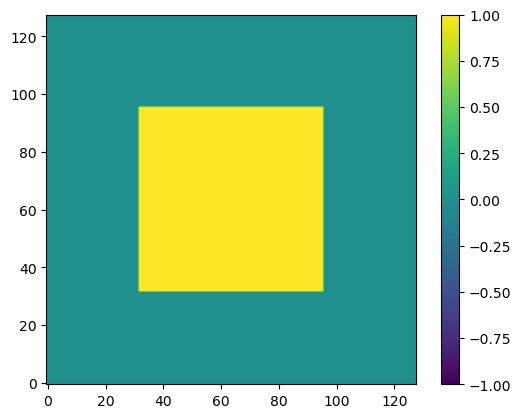

In [19]:
in_field, out_field = initialize_fields(mode="square")
time = performance_array_vectorial_pointwise(in_field, out_field, plot=True)
print(f"Arrays (vectorial): {time:.2f} s")

In [20]:
%%timeit
in_field, out_field = initialize_fields(mode="square")
performance_array_vectorial_pointwise(in_field, out_field)

314 ms ± 7.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
def performance_array_vectorial_sin_pointwise(in_field, out_field, plot=False):
    """
    Pointwise stencil with arrays and without X,Y,Z loops applying sin() to each point N_ITER times.
    The output is the time it took to run the stencil function in seconds.
    """    
    # Apply pointwise copy stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        out_field = np.sin(in_field)
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()
    
    if plot:
        plot_field(out_field)

    return toc - tic

Arrays (vectorial + sin): 0.73 s


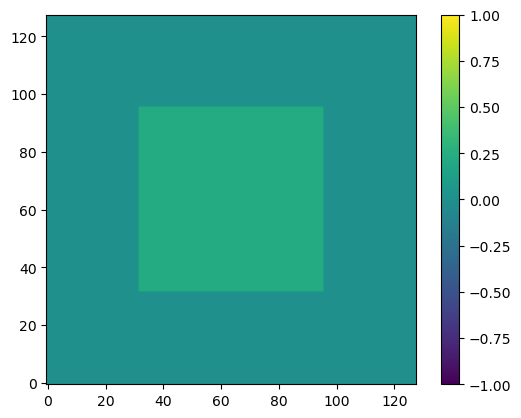

In [22]:
in_field, out_field = initialize_fields(mode="square")
time = performance_array_vectorial_sin_pointwise(in_field, out_field, plot=True)
print(f"Arrays (vectorial + sin): {time:.2f} s")

In [23]:
%%timeit 
in_field, out_field = initialize_fields(mode="square")
performance_array_vectorial_sin_pointwise(in_field, out_field)

750 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The conclusion of these first tests is that Python loops are **terribly slow**. And using NumPy arrays incorrectly, i.e., keeping the `for` loops makes things even worse.

However, if we use **NumPy arrays** correctly we increase a lot the performance. The simplest pointwise stencil (copy) is **~150x faster**, and the pointwise stencil applying `sin()` is **~7x faster**.

# 1D stencils

1D stencils updating with values from the same row or same colum only and with periodic boundary conditions.

$$
a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]
$$

$$
a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]
$$

The facotr 1/2 is to avoid getting huge numbers when `N_ITER` is large with the simple initialization patterns we defined before.

### $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [24]:
def performance_list_1D_same_col_row_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                    # Periodic boundary condition
                    out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [25]:
in_field, out_field = initialize_fields(mode="vertical-bars")

Lists: 49.31 s
49.8 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


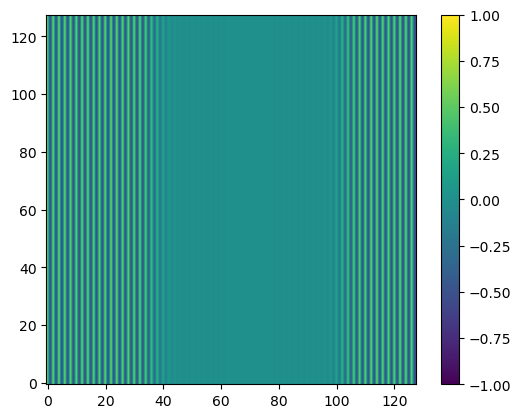

In [26]:
time = performance_list_1D_same_col_row_update(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists: {time:.2f} s")
%timeit performance_list_1D_same_col_row_update(in_field.tolist(), out_field.tolist())

In [27]:
def performance_list_1D_same_col_col_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

Lists: 21.39 s
21.6 s ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


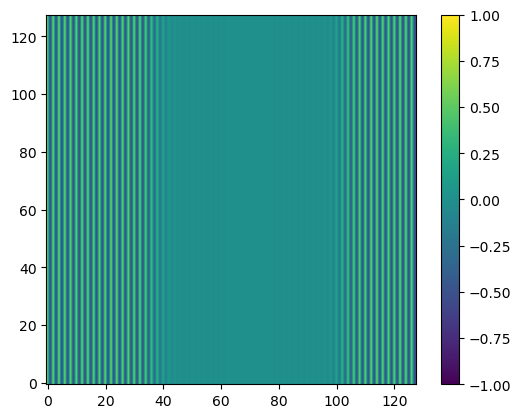

In [28]:
time = performance_list_1D_same_col_col_update(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists: {time:.2f} s")
%timeit performance_list_1D_same_col_col_update(in_field.tolist(), out_field.tolist())

If our stencil update only uses values from the same row, we should loop the field row-wise to maximize the cache hits. Working with python lists the performance difference is very noticeable.

In [29]:
def performance_array_1D_same_col_vectorial(in_field, out_field, plot=False):    
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)

    return toc - tic

Arrays: 0.83 s


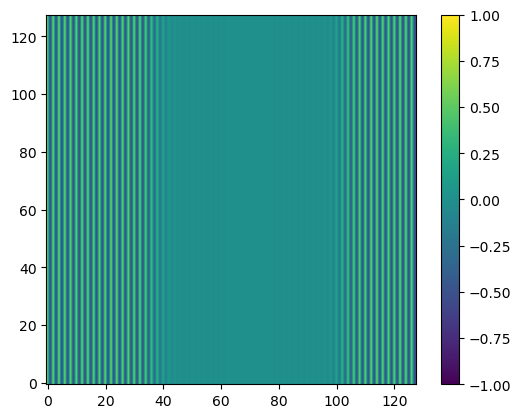

In [30]:
in_field, out_field = initialize_fields(mode="vertical-bars", order="C")
time = performance_array_1D_same_col_vectorial(in_field, out_field, plot=True)
print(f"Arrays: {time:.2f} s")

In [31]:
%%timeit
in_field, out_field = initialize_fields(mode="vertical-bars", order="C")
performance_array_1D_same_col_vectorial(in_field, out_field)

785 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Arrays: 0.67 s


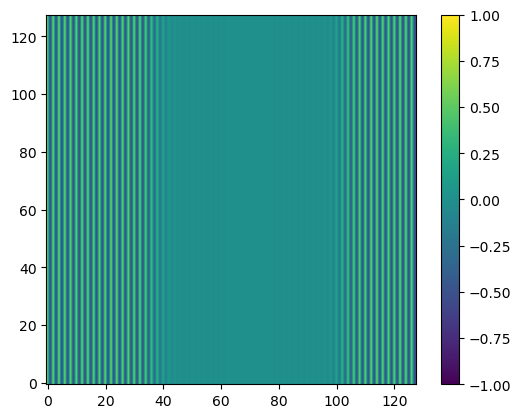

In [32]:
in_field, out_field = initialize_fields(mode="vertical-bars", order="F")
time = performance_array_1D_same_col_vectorial(in_field, out_field, plot=True)
print(f"Arrays: {time:.2f} s")

In [33]:
%%timeit 
in_field, out_field = initialize_fields(mode="vertical-bars", order="F")
performance_array_1D_same_col_vectorial(in_field, out_field)

666 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


By default, NumPy arrays are stored row-wise (C style), but this can be changed using the argument `order`. That is why we see a performance increase if we explicitly initialized the fields col-wise (Fortran style).

## $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [34]:
def performance_list_1D_same_row_row_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j+1][i] - in_field[k][j][i])
                out_field[k][NY-1][i] = 0.5 * (in_field[k][0][i] - in_field[k][NY-1][i])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [35]:
in_field, out_field = initialize_fields(mode="horizontal-bars")

Lists: 25.08 s
24.4 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


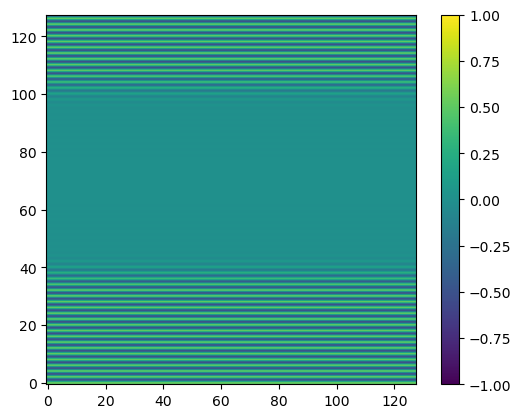

In [36]:
time = performance_list_1D_same_row_row_update(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists: {time:.2f} s")
%timeit performance_list_1D_same_row_row_update(in_field.tolist(), out_field.tolist())

In [37]:
def performance_list_1D_same_row_col_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY-1):
                for i in range(NX):
                    out_field[k][j][i] = 0.5 * (in_field[k][j+1][i] - in_field[k][j][i])
                    out_field[k][NY-1][i] = 0.5 * (in_field[k][0][i] - in_field[k][NY-1][i])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

Lists: 46.10 s
46.1 s ± 70.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


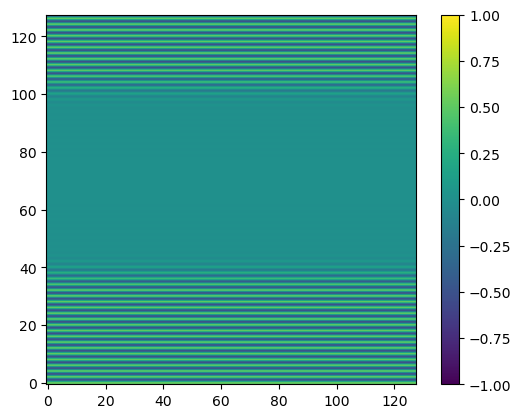

In [38]:
time = performance_list_1D_same_row_col_update(in_field.tolist(), out_field.tolist(), plot=True)
print(f"Lists: {time:.2f} s")
%timeit performance_list_1D_same_row_col_update(in_field.tolist(), out_field.tolist())

Similary, if our stencil update only uses values from the same col, we should loop the field col-wise to benefit from the cache.

In [39]:
def performance_array_1D_same_row_vectorial(in_field, out_field, plot=False):    
    # Apply 1D stencil
    tic = timeit.default_timer()
    for iter in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)

    return toc - tic

Arrays: 0.71 s


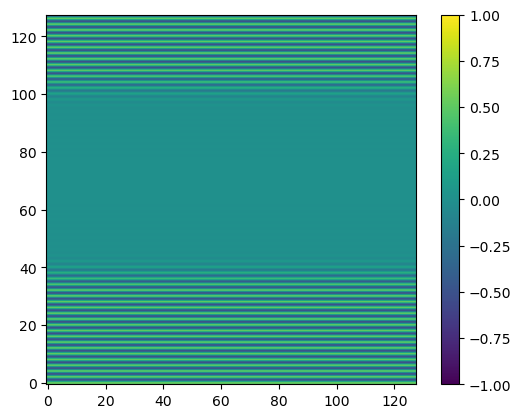

In [40]:
in_field, out_field = initialize_fields(mode="horizontal-bars", order="C")
time = performance_array_1D_same_row_vectorial(in_field, out_field, plot=True)
print(f"Arrays: {time:.2f} s")

In [41]:
%%timeit 
in_field, out_field = initialize_fields(mode="vertical-bars", order="C")
performance_array_1D_same_row_vectorial(in_field, out_field)

603 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Arrays: 0.64 s


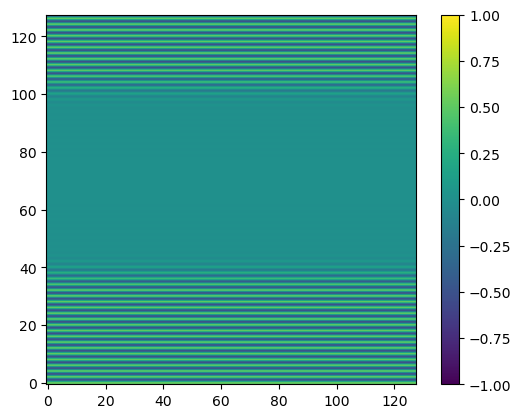

In [42]:
in_field, out_field = initialize_fields(mode="horizontal-bars", order="F")
time = performance_array_1D_same_row_vectorial(in_field, out_field, plot=True)
print(f"Arrays: {time:.2f} s")

In [43]:
%%timeit 
in_field, out_field = initialize_fields(mode="vertical-bars", order="F")
performance_array_1D_same_row_vectorial(in_field, out_field)

627 ms ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And once again, we observe the same when working with NumPy arrays. In this case, choosing the col-wise storage is better to maximize the number of hits in the cache when updating the field.

# Accelerate with Numba

**TODO:** update the summary notebook with the Numba tests

# Accelerate with Gt4Py

**TODO:** update the summary notebook with the Gt4Py tests

In [12]:
# gt4py requires all external functions be defined with the heading

@gtscript.function
def diff_horizontal(in_field):
    # Apply 1D stencil in gt4py style
    out_field[0, 0, 0] = in_field[1, 0, 0] - in_field[0, 0, 0]
    return out_field

# Create definition function of gt4py stencil calculation
def gt_1D_update_row_def(
    in_field: gtscript.Field[float],
    out_field: gtscript.Field[float],
):

    from __gtscript__ import PARALLEL, computation, interval
    from __external__ import diff_horizontal
    
    with computation(PARALLEL), interval(...):
        out_field = diff_horizontal(in_field)

# Apply iteration
def gt_1D_row_apply(get_1D_update_row_stencil, in_field, out_field, N_TIER=1):
    NX = in_field.shape[0] - 1
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        NX,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for iter in range(N_ITER):
        # Update halo value
        in_field[NX, :, :] = in_field[0, :, :]
        
        get_1D_update_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        else:
            in_field[NX, :, :] = in_field[0, :, :]

def performance_gt_1D_row(dtype="np.float64", backend="numpy", plot=False):
    
    # Create halos 
    dorigin = (1, 0, 0)
    
    # Create in_field and out_field in gt4py style
    in_field = gt.storage.zeros(
        backend,
        dorigin,
        (NX + 1, NY, NZ),
        dtype=float
    )
    out_field = gt.storage.zeros(
        backend,
        dorigin,
        (NX + num_halo, NY, NZ),
        dtype=float
    )
    in_field[: NX//2 : 2, :, :] = 1
    
    # Compile stencil
    gt_1D_update_row_stencil = gtscript.stencil(
        definition=gt_1D_update_row_def,
        backend=backend,
        externals={"diff_horizontal": diff_horizontal}
    )
    
    # warmup caches
    gt_1D_row_apply(get_1D_update_row_stencil, in_field, out_field, N_TIER=1)

    # time the actual work
    tic = time.time()
    gt_1D_row_apply(get_1D_update_row_stencil, in_field, out_field, N_TIER=N_ITER)
    toc = time.time()
    print(f"Elapsed time for work = {toc - tic} s")

    if plot:
        # plot the output field
        plt.imshow(np.asarray(out_field[:, :, 0]), origin="lower", vmin=-1, vmax=1)
        plt.colorbar()    

In [13]:
performance_gt_1D_row(dtype=float, backend="numpy", plot=True)

TypeError: zeros() got multiple values for argument 'dtype'

# Appendices

## np.sin() vs math.sin()

There is no doubt that `np.sin()` is faster than `math.sin()` when applied to large NumPy arrays. But this function has an overhead cost when applied to single elements. Here we show that `math.sin()` is more efficient than `np.sin()` when applied to 4 or less elements. However, the overhead of a Python loop is even worse than the overhead of `np.sin()`.

In [44]:
rng = np.random.default_rng()
x = rng.random(100)

`np.sin()` is ~7.7 times slower than `math.sin()` when applied to a single value.

In [45]:
%timeit math.sin(x[0])

352 ns ± 3.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [46]:
%timeit np.sin(x[0])

2.09 µs ± 6.82 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


However, we loose part of this performance the moment we use a single for loop.

In [47]:
%timeit for i in range(1): math.sin(x[i])

658 ns ± 2.21 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [48]:
%timeit np.sin(x[:1])

1.31 µs ± 7.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In any case, even without for loops, `math.sin()` becomes slower than `np.sin()` the moment we need to compute more than four values.

In [49]:
%timeit math.sin(x[0]), math.sin(x[1]), math.sin(x[2]), math.sin(x[3]), math.sin(x[4]), math.sin(x[5])

2.05 µs ± 9.26 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [50]:
%timeit np.sin(x[:6])

1.22 µs ± 8.62 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


This is because `np.sin()` computes these values in parallel, while the `math.sin()` computes them sequentially.

## Different dtypes affect performance

In [51]:
dtypes_ = [np.float16, np.float32, np.float64, np.float128]

AttributeError: module 'numpy' has no attribute 'float128'

I think there might be a difference in performance depending on the numpy `dtype` we use for the fields. If we have time we can explore this at the end.

**TODO:** Verify this with different computers and in the cluster.